# Laser Tomography

Phase screens are computed with an `Atmosphere` and a `Source` object.
Lets import the `ceo` module first.

In [1]:
import math
import numpy as np
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


The atmosphere is defined with

In [2]:
atm =  ceo.GmtAtmosphere(0.15,60)

A constellation of 6 Laser guide stars evenly located on a 1 arcmin diameter circle is defined first,

In [3]:
NL = 60
NA = NL+1
lgs = ceo.Source("V",
                 zenith=np.ones(6)*30*math.pi/180/3600,
                 azimuth=np.linspace(0,5,6)*2*math.pi/6,
                 height = 90e3,
                 resolution=(NA,NA))

The telescope pupil is defined as the Giant Magellan Telescope and mask for the deformable mirror actuators is also set.

In [4]:
D = 25.5
#tel = ceo.Telescope(NL*16)
#dm  = ceo.Telescope(NA)
tel = ceo.GMT(NL*16,D)
dm  = ceo.Mask(NA,D)

A `Centroiding` object is defined, it will contains the phase screen gradient corresponding to the LGS.
The `fried_geometry` method computes the DM valid actuator mask according to the telescope pupil shape and the given intensity `threshlod`.
The `lgs` `Source` object is masked with the dm mask.

In [5]:
d = D/NL
cog = ceo.Centroiding(NL,N_SOURCE=lgs.size)
cog.fried_geometry(dm, tel, 16, 0.5)
lgs.masked(dm)

In [6]:
dm_mask = dm.f

The phase screen gradient is computed with the `Atmosphere` method `get_phase_screen_gradient`.
The gradient is computed over a square lenslet array of size $N_L \times N_L$ with $d$ the pitch in meter.
The phase screen gradient is computed for a given `Source` object that contains one or more guide stars.
The phase screen gradient can be computed for a given time delay.
The $c_x$ and $c_y$ centroids are saved in a `Centroiding` object.

In [7]:
atm.get_phase_screen_gradient(cog,NL,d,lgs,0.0)
c = cog.c.host(units='arcsec')

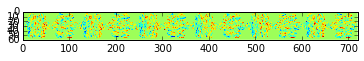

In [8]:
imshow(c.reshape(NL*lgs.size*2,NL).transpose(),interpolation='none')
#ceog.heatmap(c.reshape(NL*6*2,NL).transpose(), filename=PLOTLY_PATH+"wavefront gradient")

The on-axis source is defined and is propagated throught the atmosphere:

In [9]:
src = ceo.Source("K",resolution=(NA,NA))
src.masked(dm)
atm.get_phase_screen(src,d,NA,d,NA,0.0)

From the phase gradient, the phase screen can be reconstructed with a linear minimim mean square error reconstructor (LMMSE).
A `Lmmse` object is used to perform the phase estimation.
The parameters are:
- an `Atmosphere` object,
- a `Source` object representing the guide star(s),
- a `Source` object representing the star(s) in the estimation direction(s),
- the wavefront sampling step in meter,
- the number of sample across the wavefront,
- a `Mask` object representing the pupil,
- the iterative solver.

In [10]:
src_lmmse = ceo.Lmmse(atm,lgs,src,d,NL,dm,"MINRES")

In [11]:
et = ceo.StopWatch()
et.tic()
src_lmmse.estimation(cog)
et.toc()
src_phase = src.phase
src_lmmse_phase = src_lmmse.phase

In [12]:
ps_e = src_lmmse_phase.host(units='micron',
                            zm=True,mask=dm_mask.host()) - src_phase.host(units='micron',zm=True,mask=dm_mask.host_data)
print "wavefront error: %6.2fnm" % (np.std(ps_e[dm_mask.host_data.reshape((NA,NA))!=0])*1e3)

wavefront error: 119.69nm


<matplotlib.colorbar.Colorbar instance at 0x2b15281f7c68>

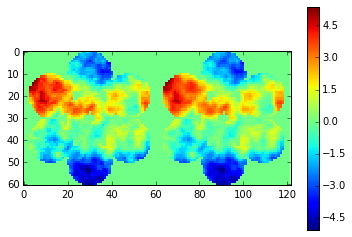

In [13]:
imshow(np.concatenate((src_phase.host_data, src_lmmse_phase.host_data),axis=1),
             interpolation='none')
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b152837d8c0>

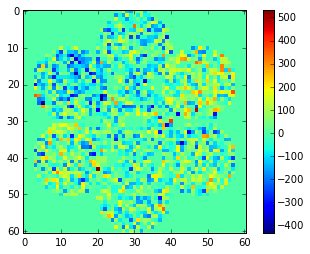

In [14]:
imshow(ps_e*1e3,interpolation='none')
colorbar()

## Wavefront error vs. LGS radius

In [14]:
azi = np.linspace(0,5,6)*2*math.pi/6
zen_radius = np.linspace(5,60,12)
zen_radius

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.])

In [15]:
def eval_wfe(_zen_radius,n_sample):
    print "LGS asterism radius: %4.1farcsec" % _zen_radius
    lgs = ceo.Source("V",
                 zenith=np.ones(6)*_zen_radius*math.pi/180/3600,
                 azimuth=azi,
                 height = 90e3,
                 resolution=(NA,NA))
    src_lmmse = ceo.Lmmse(atm,lgs,src,d,NL,dm,"MINRES")
    var_ps_e = 0
    for k_sample in range(n_sample):
        atm.reset()
        atm.get_phase_screen_gradient(cog,NL,d,lgs,0.0)
        src_lmmse.estimation(cog)
        atm.get_phase_screen(src,d,NA,d,NA,0.0)
        src.masked(dm)
        src_phase = src.phase
        src_lmmse_phase = src_lmmse.phase
        ps_e = src_lmmse_phase.host(units='micron') - src_phase.host(units='micron')
        ps_e = np.reshape(ps_e,(NA**2,1))
        var_ps_e += np.var(ps_e[dm_mask.host_data!=0])
    std_ps_e =  math.sqrt(var_ps_e/n_sample)*1e3
    print " -> wavefront error: %6.2fnm" % (std_ps_e)
    return std_ps_e

In [16]:
wfe = [eval_wfe(x,200) for x in zen_radius]

LGS asterism radius:  5.0arcsec
 -> wavefront error: 208.47nm
LGS asterism radius: 10.0arcsec
 -> wavefront error: 173.47nm
LGS asterism radius: 15.0arcsec
 -> wavefront error: 151.84nm
LGS asterism radius: 20.0arcsec
 -> wavefront error: 140.01nm
LGS asterism radius: 25.0arcsec
 -> wavefront error: 134.12nm
LGS asterism radius: 30.0arcsec
 -> wavefront error: 134.59nm
LGS asterism radius: 35.0arcsec
 -> wavefront error: 139.29nm
LGS asterism radius: 40.0arcsec
 -> wavefront error: 145.24nm
LGS asterism radius: 45.0arcsec
 -> wavefront error: 149.04nm
LGS asterism radius: 50.0arcsec
 -> wavefront error: 154.28nm
LGS asterism radius: 55.0arcsec
 -> wavefront error: 159.33nm
LGS asterism radius: 60.0arcsec
 -> wavefront error: 164.54nm


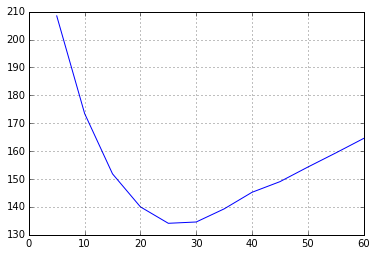

In [17]:
plot(zen_radius,wfe)
grid()